# Описание эксперимента по построению тематического спектра новостного потока

## Попов Артём, ВМК МГУ

### Цель эксперимента: 
* построение иерархической тематической модели новостного потока
* визуализация модели с помощью heatmap и дендрограммы

### Данные: 
* 21525 новостей в период с 16 апреля 2016 по 15 июня 2016
* у каждой новости есть, текст заголовок, метка времени, метка издания

### Эксперимент 

В этом эксперименте попробуем не применять "сложные" методы построения иерархий, а построить иерархию с помощью кластеризации матрицы $\Phi$, получившейся после построения обычной тематической модели.


#### Обработка коллекции

Коллекция была лемматезирована с помощью pymorphy. В коллекции были выделены биграммы на этапе обработки. На выходе получились документы с 4 модальностями: текст, заголовок, время, источник.

#### Подключение библиотек

In [1]:
import glob
import time

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm # для подключения русских шрифтов
import seaborn as sns # seaborn для визуализации
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import gridspec as gridspec
%matplotlib inline

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

import artm

In [15]:
artm.version()

'0.8.1'

#### Вспомогательные функции
Функции для вывода параметров модели, построения графиков, подсчёта когерентности

In [2]:
# Функция для построения графика перплексии и разреженности
def figures(model):
    x = range(model.num_phi_updates)[:]
    fig, ax1 = plt.subplots()
    ax1.plot(x, model.score_tracker['PerplexityScore'].value[:], 'g-', linewidth=2, label="Perplexity")
    ax1.set_ylabel('Perplexity', color='g')
    ax11 = ax1.twinx()
    ax11.plot(x, model.score_tracker['SparsityPhiScore'].value[:], 'b--', linewidth=2, label="Phi")
    ax11.plot(x, model.score_tracker['SparsityThetaScore'].value[:], 'r--', linewidth=2, label="Theta ")
    ax11.set_ylabel('Ratio', color='r')
    ax11.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.)
    ax1.grid(True)
    plt.show()
    

# Функция для печати значений метрик модели
def print_measures(model_artm):
    print 'Sparsity Phi: {0:.3f}'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)

    print 'Sparsity Theta: {0:.3f}'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value)

    print 'Kernel contrast: {0:.3f}'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast)

    print 'Kernel purity: {0:.3f}'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity)

    print 'Perplexity: {0:.3f}'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)


# Функция для подсчёта когерентности.
#Параметр pmi_tuple - кортеж из матрицы (csr_matrix) и списка слов, соответствующим её строкам 
def count_coherence(model_artm, pmi_tuple, k=10, test_topics=None):
    pmi_matr, pmi_words = pmi_tuple
    phi = model_artm.get_phi(class_ids=['text'])
    coherence = np.zeros(phi.shape[1])
    if test_topics is None:
        name_of_topics = phi.columns
    else:
        name_of_topics = test_topics
    
    for i, topic in enumerate(name_of_topics):
        one_column = phi[topic]
        pos_in_phi = np.argsort(one_column)[-k:]
        pos_in_pmi = np.where(np.in1d(np.array(pmi_words), phi.index[pos_in_phi]))[0]
        temp_arr = pmi_matr[pos_in_pmi].toarray()[:, pos_in_pmi]
        temp_arr -= np.eye(k) * np.diag(temp_arr)
        coherence[i] = np.sum(temp_arr) / (k * (k - 1))
    
    return coherence


# Волшебная функция для вывода для модели всего чего хочется
def test_all(model_artm, pmi_tuple, draw_picture=False, print_topics=False, test_topics=None):
    if test_topics is None:
        test_topics = model_artm.phi_.columns
    
    coh10 = count_coherence(model_artm, pmi_tuple, 10, test_topics)
    coh100 = count_coherence(model_artm, pmi_tuple, 100, test_topics)

    print "COH 10: mean", np.mean(coh10), "median", np.median(coh10)
    print "COH 100: mean", np.mean(coh100), "median", np.median(coh100)
    
    print_measures(model_artm)
    
    if draw_picture == True:
        figures(model_artm)
    
    if print_topics == True:
        for i, topic in enumerate(model_artm.topic_names):
            print topic + ':', coh10[i], ':', coh100[i], ':'
            print " ".join(model_artm.score_tracker['TopTokensScoreText'].last_tokens[topic])
            print
            

# Функция для рисования графиков p(t|time)
# proba_t_in_time - массив, по умолчанию берётся из модальности time, можно задать свой
# можно выводить графики сразу для двух моделей (не помню уже, зачем я это добавлял)
def plot_topic_time_graphic(model, num_of_topic=0, proba_t_in_time=None,
                            model2=None, proba_t_in_time2=None, scale='linear', possible_days=None):
    
    if proba_t_in_time is None:
        proba_t_in_time = np.array(model.get_phi(class_ids=['time'])).T
    
    if model2 is not None:
        if proba_t_in_time2 is None:
            proba_t_in_time2 = np.array(model2.get_phi(class_ids=['time'])).T
    
    title = 'topic_' + str(num_of_topic)
    
    fig = plt.figure()
    plt.plot(range(proba_t_in_time.shape[1]), proba_t_in_time[num_of_topic], '-o')
    if model2 is not None:
            plt.plot(range(proba_t_in_time2.shape[1]), proba_t_in_time2[num_of_topic], '-o')
    
    
    plt.title(title)
    plt.ylabel('topic popularity')
    plt.xlabel('month-day')
    plt.yscale(scale)
    if possible_days is not None:
        len_ticks = len(possible_days[::5])
        plt.xticks(np.linspace(0, proba_t_in_time.shape[1], len_ticks), [x[5:] for x in possible_days[::5]],
                   fontsize=10, rotation=60)

    plt.xlim(0, 52)
    plt.grid()

    if scale == 'linear':
        y_min, y_max = np.amin(proba_t_in_time[num_of_topic]) / 1.1, np.amax(proba_t_in_time[num_of_topic]) * 1.1
        if model2 is not None:
            y_min = np.minimum(y_min, np.amin(proba_t_in_time2[num_of_topic]) / 1.1)
            y_max = np.maximum(y_min, np.amax(proba_t_in_time2[num_of_topic]) * 1.1)
        delta = (y_max - y_min) / 20
    elif scale == 'log':
        pos_val = proba_t_in_time[num_of_topic][proba_t_in_time[num_of_topic] > 0]
        y_min, y_max = np.amin(pos_val) / 10, np.amax(proba_t_in_time[num_of_topic]) * 10
        if model2 is not None:
            pos_val = proba_t_in_time2[num_of_topic][proba_t_in_time2[num_of_topic] > 0]
            y_min = np.minimum(y_min, np.amin(pos_val) / 10)
            y_max = np.maximum(y_max, np.amax(proba_t_in_time2[num_of_topic]) * 10)
        delta = ((np.log10(y_max * 0.9) - np.log10(y_min)) / 10)
    plt.ylim(y_min, y_max)
    
    n_tokens = 9
    list_of_tokens = model.score_tracker['TopTokensScoreText'].last_tokens[title][:n_tokens]

    fp1 = fm.FontProperties( fname = "/usr/share/fonts/truetype/retrospective_cyriilic.otf" , size=12)
    for i in range(n_tokens):
        if scale == 'linear':
            plt.text( 4, y_max * 0.9 - (i + 1) * delta, list_of_tokens[i], fontproperties = fp1)
        elif scale == 'log':
            plt.text( 4, y_max / (10 ** (delta * (i + 1))), list_of_tokens[i], fontproperties = fp1)
            
    return fig

#### Загрузка PMI матрицы в память

PMI матрица создавалась с помощью скриптов, которые лежат здесь:

https://bitbucket.org/omerlevy/hyperwords

(PMI матрица, использовавшаяся в этом эксперименте не совсем честная - она строилась по plain text, содержащем биграммы)

In [3]:
file_pmi = np.load('pmi/pmi.npz')
file_words = open('pmi/pmi.words.vocab')

pmi_words = file_words.readlines()
pmi_words = map(lambda x: x.strip().decode('utf-8'), pmi_words)

size = tuple(file_pmi['shape'])
pmi_matr = csr_matrix((file_pmi['data'], file_pmi['indices'], file_pmi['indptr']), shape=size)

#### Инициализация модели

In [4]:
data_path = 'mediaplanning/preprocessed/UCI_full'
batches_path = 'batches'

In [5]:
if len(glob.glob(batches_path + "/*.batch")) < 1:
    batch_vectorizer = artm.BatchVectorizer(data_path=data_path + '', collection_name='mediaplanning',
                                            data_format='bow_uci', batch_size = 1000, 
                                            target_folder=batches_path)
else:
    batch_vectorizer = artm.BatchVectorizer(data_path=batches_path, 
                                            data_format='batches')

In [6]:
my_dictionary = artm.Dictionary()

if len(glob.glob(batches_path + "/*.dict")) < 1:
    my_dictionary.gather(data_path=batches_path, vocab_file_path=data_path + '/vocab.mediaplanning.txt')
    my_dictionary.save(dictionary_path=batches_path + '/mediaplanning_dictionary')

my_dictionary.load(dictionary_path=batches_path + '/mediaplanning_dictionary.dict')

In [7]:
# не используем никакие модальности кроме текста

class_ids = {
    'text': 1.0,
     #'source': 1.0,
     #'time':5.0,
     #'title':1.0
}


num_of_topics = 200

specific_topics = [unicode('topic_' + str(x)) for x in range(0, num_of_topics - 10)]
background_topics = [unicode('topic_' + str(x)) for x in range(num_of_topics - 10, num_of_topics)]

scores_artm = [artm.PerplexityScore(name='PerplexityScore',
                                    use_unigram_document_model=False,
                                    dictionary=my_dictionary,
                                    class_ids=['text']),
               artm.SparsityPhiScore(name='SparsityPhiScore', class_id='text'),
               artm.SparsityThetaScore(name='SparsityThetaScore'),
               artm.TopicKernelScore(name='TopicKernelScore',
                                     probability_mass_threshold=0.25, class_id='text'),
               artm.TopTokensScore(name='TopTokensScoreText',class_id = 'text', num_tokens=20)]

regularizers_artm = [artm.DecorrelatorPhiRegularizer(name='DeccorPhi', class_ids=['text'], gamma=0, tau=0),
                    artm.SmoothSparsePhiRegularizer(name='SparsePhi', class_ids=['text'],
                                                    topic_names=specific_topics, gamma=0, tau=0),
                    artm.SmoothSparsePhiRegularizer(name='SmoothPhi', class_ids=['text', 'source'],
                                                    topic_names=background_topics, gamma=0, tau=0),
                    artm.SmoothSparseThetaRegularizer(name='SparseTheta',
                                                    topic_names=specific_topics, tau=0),
                    artm.SmoothSparseThetaRegularizer(name='SmoothTheta',
                                                    topic_names=background_topics, tau=0)]

#### Тематическая модель

* 200 тем
* 190 предметных, 10 фоновых
* предметные: постепенное разреживание $\Phi$ и $\Theta$, декоррелирование
* фоновые: сглаживание $\Phi$ и $\Theta$, декоррелирование
* модальность заголовка была выкинута во всех моделях
* модальности времени и источника применялись в некоторых моделях, но в модели, которая описана ниже отсутствуют
* модель обучалась с помощью оффлайнового алгоритма

In [12]:
model_artm = artm.ARTM(num_topics=num_of_topics,
                       class_ids=class_ids, dictionary=my_dictionary,
                       scores=scores_artm,
                       regularizers=regularizers_artm)

# этап 1 - сильная декорреляция
model_artm.regularizers['DeccorPhi'].tau = 0.05
model_artm.regularizers['DeccorPhi'].gamma = 0
model_artm.regularizers['SmoothPhi'].gamma = 0.05
model_artm.regularizers['SmoothTheta'].tau = 0.05
model_artm.regularizers['SparsePhi'].tau = 0
model_artm.regularizers['SparseTheta'].tau = 0

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

# этап 2 - подключение сглаживания фоновых

model_artm.regularizers['SmoothPhi'].tau = 0.05
model_artm.regularizers['SmoothTheta'].tau = 0.05

model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

# этап 3 - подключение разреживания предметных

model_artm.regularizers['SparsePhi'].tau = -0.05
model_artm.regularizers['SparseTheta'].tau = -0.0001
    
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)

model_artm.regularizers['SparsePhi'].tau = -0.1
model_artm.regularizers['SparseTheta'].tau = -0.001
    
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)

model_artm.regularizers['SparsePhi'].tau = -0.1
model_artm.regularizers['SparseTheta'].tau = -0.1
    
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)


COH 10: mean 28.554081044 median 18.6671607842
COH 100: mean 18.5517065638 median 13.4024253784
Sparsity Phi: 0.923
Sparsity Theta: 0.831
Kernel contrast: 0.669
Kernel purity: 0.388
Perplexity: 3208.519


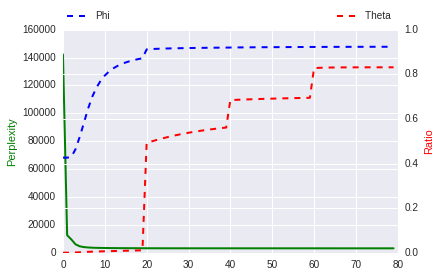

topic_0: 12.133852396 : 7.04675772185 :
книга писатель поэт литература автор читать библиотека роман читатель литературный стих книжный писать произведение чтение написать жизнь издательство журнал прочитать

topic_1: 29.8264977606 : 17.755318958 :
робот космос планета луна космонавт космический земля марс полёт орландо гей гагарин планет телескоп звезда земной матин солнце орбита аппарат

topic_2: 49.1255424766 : 20.9390235665 :
ракета спутник космический космодром запуск старт пуск роскосмос восточный союз носитель орбита аппарат ракетный космос космодром_восточный байконур космический_аппарат полёт ангар

topic_3: 5.69773556446 : 2.81170740162 :
министр премьер встреча вопрос израиль обсудить визит вчера переговоры премьера глава конференция дмитрий_медведев тема лидер правительство напомнить встретиться проблема израильский

topic_4: 22.493686593 : 10.5918807868 :
интернет пользователь сервис реклама яндекс приложение мессенджер контент рекламный аудитория facebook сообщение роском

In [13]:
test_all(model_artm, (pmi_matr, pmi_words), draw_picture=True, print_topics=True, test_topics=specific_topics)

#### Визуализация

В данном исследовании мы хотим построить визуализацию с помощью heatmap.
По оси $y$ мы хотим отложить темы, по оси $x$ время.
Чем больше вероятность p(тема|время), тем ярче ячейка heatmap. 
При построении heatmap производится агломеративная кластеризация строк.
Некоторые пакеты позволяют вывести эту кластерную структуру на экран в виде дендрограммы (но не python). 


Нетривиальная идея дендрограммы в том, что когда она строится, фактически происходит проецирование метрического пространства объектов на одномерную ось: в процессе дендрограммы построения близкие темы и близкие кластеры многократно переставляются так, чтобы в итоге близкие оказывались рядом. Один из методов построения позволяет с помощью перестановок правых и левых поддеревьев внутренних вершин (т.е. с сохранением структуры кластеров) добиться того, чтобы сумма мер схожести между соседними листьями в дендрограмме была максимальной. 

После построения кластерной структуры, можно преобразовать картинку, выделив большие кластеры и отделив их друг от друга.

Оригинальная статья:
    http://phdtree.org/pdf/13882828-fast-optimal-leaf-ordering-for-hierarchical-clustering/

Этот метод не реализован в python библиотеках, но есть сторонняя реализация на github.

Страничка на git:
https://gist.github.com/mlovci/dc23a1d30076746cf0d8

    git clone https://gist.github.com/dc23a1d30076746cf0d8.git

Скрипт не работает с новой версией scipy (у меня версия 0.18.0 - скрипт не работает).
Я переписал, чтобы работал на ней.

Мой fork: https://gist.github.com/arti32lehtonen/8c6a8e60ca84d7345ed5ba71d7396394
    
    git clone https://gist.github.com/8c6a8e60ca84d7345ed5ba71d7396394.git

Класс OLO - принимает матрицу признаков(pandas dataframe), метрику для кластеризации (функция от x, y)

Методы .col_order - кластеризует и сортирует столбцы, возвращает список индексов.

In [58]:
import OLO

Мы хотим оценить p(t|y=время).
Для этого нам нужно для всех тем посчитать:

$$ p(t\;|\;y) = \sum_{d \in D_y}p(t\;|\;d)p(d\;|\;y) = \sum_{d \in D_y} \theta_{td} \frac{n_d}{N_y} $$

$D_y$ - множество документов в момент времени $y$

$N_y$ - общая длина всех документов в момент времени $y$

Вместо этой велечины хотелось бы использовать модальность времени

In [75]:
file_days = open('mediaplanning/preprocessed/mediaplanning.time.txt')
days = np.array(map(lambda x: x.rstrip(), file_days.readlines()))

file_docs = open('mediaplanning/preprocessed/mediaplanning.text.txt')
docs = file_docs.readlines()

n_d = np.array(map(lambda x: len(x.split(' ')), docs))
possible_days = sorted(list(set(days)))

proba_t_in_time = np.zeros((num_of_topics, len(possible_days)))

Theta = model_artm.transform(batch_vectorizer=batch_vectorizer)

for i, day in enumerate(possible_days):
    indexes = np.where(days == day)[0] + 1
    numb_doc = indexes.shape[0]
    proba_t_in_time[:, i] = np.sum(Theta[indexes] * n_d[indexes - 1], axis=1) / np.sum(n_d[indexes - 1])

Проведем подготовительную работу, для каждой темы зададим список топ-слов:

In [76]:
phi = model_artm.get_phi(class_ids=['text'])
words = phi.index
top_tokens = map(lambda x: "  " + " ".join(x[::-1]), words[np.argsort(np.array(phi), axis=0)[-10:, :].T])
top_tokens = map(lambda x: (x[0][1:]) + " " + str(x[1]), zip(top_tokens, range(190)))

phi = np.array(model_artm.phi_)[:, :-10]
olo_data = OLO.OLO(pd.DataFrame(phi), metric=lambda x, y: np.sum((np.sqrt(x) - np.sqrt(y)) ** 2), method='complete')

Отсортируем строки:

In [77]:
good_data = proba_t_in_time[olo_data.col_order, :]

Функция для построения дополнительных кирпичиков в heatmap (после того, как построен первый):

In [78]:
def plot_part(i, ming, maxg, title='title'):
    ax1 = plt.subplot(gs[i, :])
    sns.heatmap(temp[ming:maxg], linewidth=0.2, cmap=plt.cm.Blues,
                vmin=0, vmax=0.1,
                square=True,  cbar_kws={"shrink": .4})
    ax1.set_title(title, fontsize=14)
    ax1.set_yticks(map(lambda x: x, list(range(maxg - ming))))
    ax1.set_yticklabels(np.array(top_tokens)[olo_data.col_order][::-1][-maxg:-ming], rotation='horizontal')
    plt.xticks(map(lambda x: x + 0.5, range(len(possible_days))[::2]), [x[5:] for x in possible_days[::2]],
                   fontsize=10, rotation=90)

Построим heatmap:

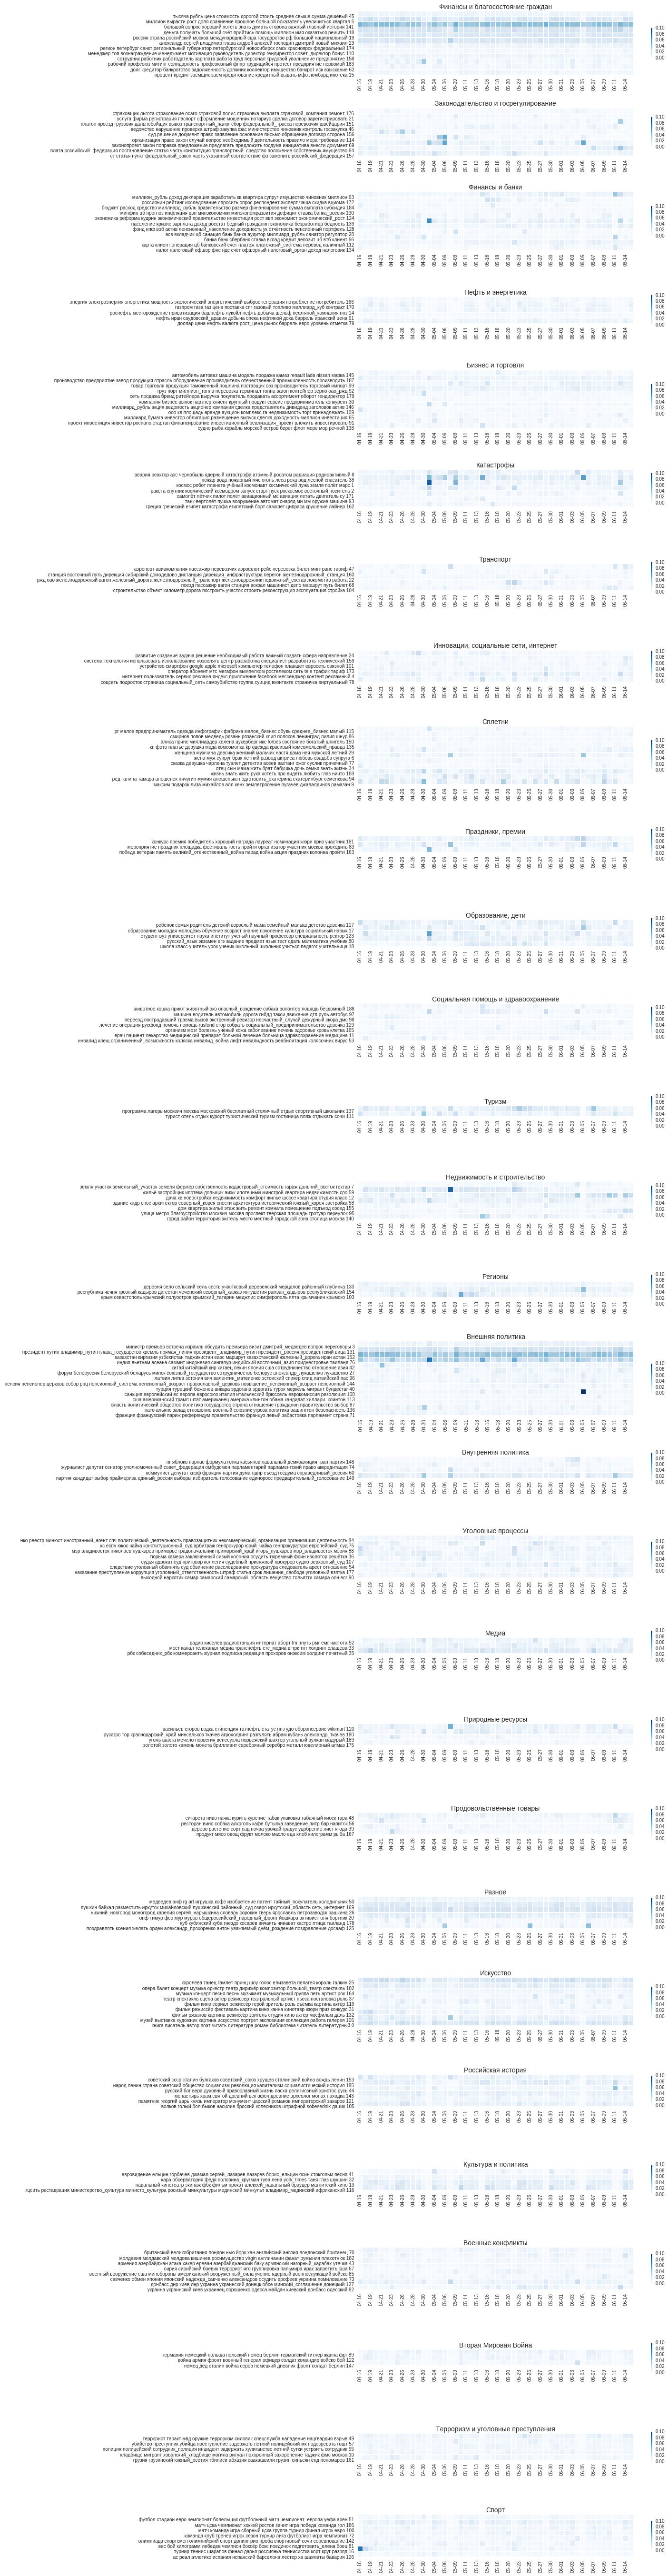

In [79]:
fig, ax = plt.subplots()

fig.set_figwidth(13) 
fig.set_figheight(100)

gs = gridspec.GridSpec(30, 30)

ax1 = plt.subplot(gs[0, :])
ming, maxg = 0, 12
sns.heatmap(good_data[ming:maxg], linewidth=0.2, cmap=plt.cm.Blues,
                        vmin=0, vmax=0.1,
            square=True,  cbar_kws={"shrink": .4})

# Построение первого кирпичика
ax1.set_title(u'Финансы и благосостояние граждан', fontsize=14)
ax1.set_yticks(map(lambda x: x, list(range(maxg - ming))))
ax1.set_yticklabels(np.array(top_tokens)[olo_data.col_order][::-1][-maxg:], rotation='horizontal')
plt.xticks(map(lambda x: x + 0.5, range(len(possible_days))[::2]), [x[5:] for x in possible_days[::2]],
                   fontsize=10, rotation=90)

# Построение всех остальных
plot_part(1, 12, 21, u'Законодательство и госрегулирование')
plot_part(2, 21, 32, u'Финансы и банки')
plot_part(3, 32, 37, u'Нефть и энергетика')
plot_part(4, 37, 48, u'Бизнес и торговля')
plot_part(5, 48, 55, u'Катастрофы')
plot_part(6, 55, 60, u'Транспорт')
plot_part(7, 60, 66, u'Инновации, социальные сети, интернет')
plot_part(8, 66, 77, u'Сплетни')
plot_part(9, 77, 80, u'Праздники, премии')
plot_part(10, 80, 85, u'Образование, дети')
plot_part(11, 85, 92, u'Социальная помощь и здравоохранение')
plot_part(12, 92, 94, u'Туризм')
plot_part(13, 94, 101, u'Недвижимость и строительство')
plot_part(14, 101, 104, u'Регионы')
plot_part(15, 104, 118, u'Внешняя политика')
plot_part(16, 118, 122, u'Внутренняя политика')
plot_part(17, 122, 130, u'Уголовные процессы')
plot_part(18, 130, 133, u'Медиа')
plot_part(19, 133, 137, u'Природные ресурсы')
plot_part(20, 137, 141, u'Продовольственные товары')
plot_part(21, 141, 147, u'Разное')
plot_part(22, 147, 156, u'Искусство')
plot_part(23, 156, 162, u'Российская история')
plot_part(24, 162, 166, u'Культура и политика')
plot_part(25, 166, 174, u'Военные конфликты')
plot_part(26, 174, 177, u'Вторая Мировая Война')
plot_part(27, 177, 182, u'Терроризм и уголовные преступления')
plot_part(28, 182, 190, u'Спорт')

plt.savefig('pictures/clusterplots/190blue_apart.pdf', bbox_inches='tight')

### Итоги

#### Преимущества модели
1) Используемый метод кластеризации действительно выделяет спектр

2) Все неинтерпретируемые темы сконцентрированы в одном кластере

3) Можно проследить интерпретируемые пики

#### Проблемы модели

1) Текущая модель не соответствует действительности. Необходима модель, способная добавлять новые темы, забывать старые.

2) Не используются никакие модальности кроме текста

3) Предложенный метод построения иерархий полуручной.

4) Есть небольшое количество фоновых тем

#### Системные проблемы

1) Нет регуляризатора для модальности времени.

2) Нет суммаризации тем.